### Clustering

In [2]:
# ensure scikit-learn’s runs single-threaded to reduce memory load.
os.environ["OMP_NUM_THREADS"] = "1"   # OpenMP threads
os.environ["MKL_NUM_THREADS"] = "1"   # MKL’s own thread pool

In [ ]:
from dotenv import load_dotenv
import os

#### Load data

In [ ]:
load_dotenv(".env")  # defaults to loading a `.env` file in the current directory

host = os.getenv("MY_SQL_HOST")
user = os.getenv("MY_SQL_USER")
password = os.getenv("MY_SQL_PASSWORD")
database = os.getenv("MY_SQL_DATABASE")

In [ ]:
import mysql.connector

def get_connection(host, user, password, database):
  mydb = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
  )
  return mydb

In [ ]:
connection = get_connection(host=host, user=user, password=password, database=database)
cursor = connection.cursor()
root_location = "E:\\applied data science capstone\\anime-recommendation\\modelling\\clustering\\exploration"

In [ ]:
query = """
SELECT
    user_id,
    anime_id,
    rating
FROM
    rating_v2
ORDER BY
    user_id;
"""
cursor.execute(query)
raw_data = cursor.fetchall()

In [ ]:
import pandas as pd

df = pd.DataFrame(raw_data, columns=["user_id", "anime_id", "rating"])
df["rating"] = pd.to_numeric(df["rating"])
# save data to file
filename = "E:\\applied data science capstone\\data\\etl\\extract\\transactions\\clustering_13_Jul.csv"
df.to_csv(filename, index=False)

In [5]:
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47161882 entries, 0 to 47161881
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 1.1 GB


In [12]:
df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

In [ ]:
# split into train, test and validate
train_df, test_validate_df = train_test_split(df, test_size=0.25, random_state=42)
test_df, validate_df = train_test_split(test_validate_df, test_size=0.2, random_state=42)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35371411 entries, 27745566 to 21081788
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 1.1 GB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9432376 entries, 36901731 to 21750476
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 287.9 MB


In [11]:
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2358095 entries, 39414737 to 31165642
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 72.0 MB


In [13]:
print(f"train percentage: {train_df.shape[0]/df.shape[0]}")
print(f"test percentage: {test_df.shape[0]/df.shape[0]}")
print(f"validate percentage: {validate_df.shape[0]/df.shape[0]}")

train percentage: 0.7499999893982178
test percentage: 0.19999999151857425
validate percentage: 0.05000001908320792


In [14]:
# save validate df for future user
filename = "E:\\applied data science capstone\\data\\etl\\extract\\transactions\\validate_8_Aug.csv"
validate_df.to_csv(filename, index=False)

In [24]:
anime_cat = train_df['anime_id'].astype('category') # create category
anime_codes = anime_cat.cat.codes # get code for categories
index_to_anime = dict(enumerate(anime_cat.cat.categories)) # create mapping for index and anime
anime_to_index = {v: k for k, v in index_to_anime.items()} # reverse mapping for index and anime

In [25]:
user_cat = train_df['user_id'].astype('category') # create category
user_codes = user_cat.cat.codes # get code for categories
index_to_user = dict(enumerate(user_cat.cat.categories)) # create mapping for index and user
user_to_index = {v: k for k, v in index_to_user.items()} # reverse mapping for index and user

In [ ]:
from scipy.sparse import coo_matrix
# build coo (non-zero values along with their coordinates), then convert to csr (format for sparse matrix)
num_users  = user_codes.max() + 1
num_animes = anime_codes.max() + 1
data = train_df['rating'].values
user_item_sparse = coo_matrix((data, (user_codes, anime_codes)), shape=(num_users, num_animes)).tocsr()

#### Training K = 2

In [27]:
from sklearn.cluster import KMeans

In [223]:
# evaluation metrics
inertia = []
silhoutte_scores = []
davies_bouldin_scores = []
precision_scores = []
recall_scores = []

In [224]:
# create cluster
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

# inertia measures how internally coherent the k-means clusters are
# lower inertia means points are closer to the centroid
# higher inertia means points are further from the centroid
inertia.append(kmeans.inertia_)

#### Assessing K = 2 

In [225]:
import numpy as np

In [226]:
# extract sample
random_generator = np.random.default_rng(42)
sample_indices = random_generator.choice(user_item_sparse.shape[0], size=3000, replace=False)
sample_matrix = user_item_sparse[sample_indices]
sample_labels = cluster_labels[sample_indices]
sample_index_to_user = { k:v for k, v in index_to_user.items() if k in sample_indices}

In [227]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

##### Silhouette

In [228]:
# silhouette score is used to determine the effectiveness of the clusters
# close to -1 means points in cluster are closer to points in other clusters
# clost to 1 means the points are close to other points in the same cluster
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.3f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.002


##### Davies-Bouldin Index

In [229]:
# davies-bouldin index is used to compare how well separated a cluster is to its size
# lower score is better as it means the clusters are more compact and the points are far apart from centroids
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.3f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 3.621


##### Visualize clusters

In [230]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
plots_location = "E:\\applied data science capstone\\anime-recommendation\\modelling\\clustering\\assessing"

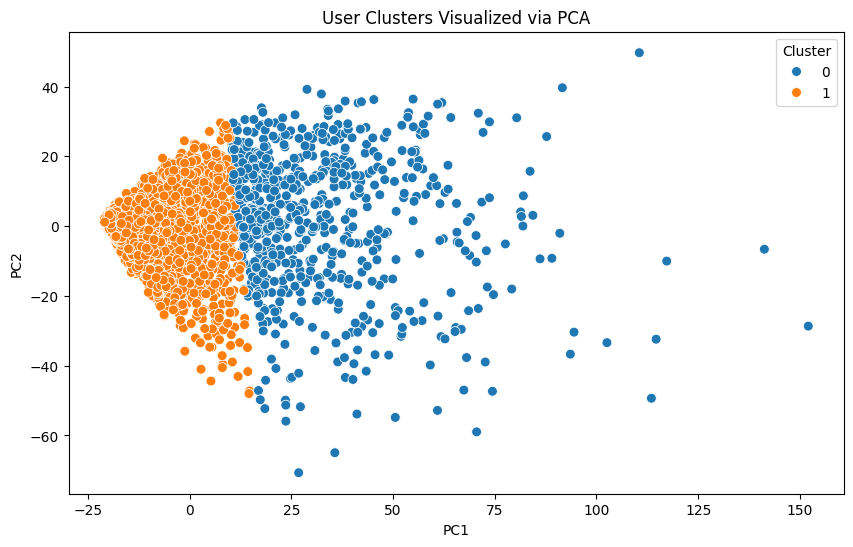

In [231]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_2.png")
plt.show()

##### Precision@2 and Recall@2

In [232]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [233]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,1
1,447249,2033,7.0,1
2,446384,31318,10.0,0
3,400930,3712,8.0,0
4,153921,37520,8.0,0


In [234]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [235]:
def precision_recall_at_k(user_id, k=5):
    # retrieve cluster for user
    cluster_id = clusters_train_df.loc[clusters_train_df["user_id"] == user_id, 'cluster'].values[0]
    cluster_profile = cluster_mean_ratings_df.loc[cluster_mean_ratings_df["cluster"] == cluster_id] \
        .drop('cluster', errors='ignore')

    # sort by rating
    recommendations = cluster_profile.sort_values(by=["rating"], ascending=False)

    # anime rated by user in test df and train df
    user_test_anime = test_df.loc[test_df["user_id"] == user_id, "anime_id"].tolist()
    user_train_anime = train_df[train_df["user_id"] == user_id]

    # recommended top-k
    recommended = recommendations.loc[~recommendations["anime_id"] \
        .isin(user_train_anime["anime_id"].unique()), "anime_id"].tolist()
    recommended_k = recommended[:k]

    # no test data for user
    if len(user_test_anime) == 0:
        return None, None

    precision = len(set(recommended_k) & set(user_test_anime)) / k
    recall = len(set(recommended_k) & set(user_test_anime)) / len(user_test_anime)
    return precision, recall

In [236]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@2: {mean_precision:.6f}")
print(f"Recall@2: {mean_recall:.6f}")

Precision@2: 0.017795
Recall@2: 0.001476


#### Training K = 3

In [237]:
# create cluster
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 3

In [238]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [239]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.3f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.023


##### Davies-Bouldin Index

In [240]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.3f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 4.691


##### Visualize clusters

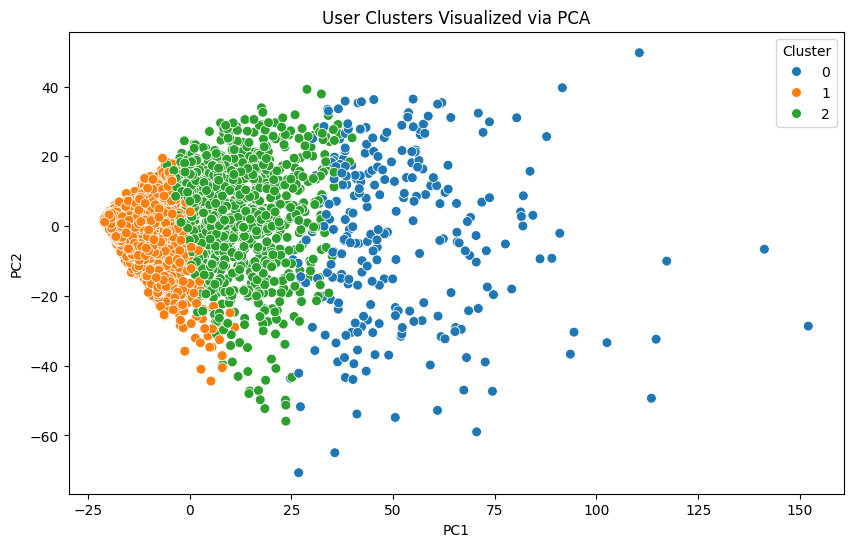

In [241]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@3 and Recall@3

In [242]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [243]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,1
2,446384,31318,10.0,2
3,400930,3712,8.0,0
4,153921,37520,8.0,0


In [244]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [245]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@3: {mean_precision:.6f}")
print(f"Recall@3: {mean_recall:.6f}")

Precision@3: 0.007657
Recall@3: 0.000430


#### Training K = 4

In [246]:
# create cluster
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 4

In [247]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [248]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.024993


##### Davies-Bouldin Index

In [249]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 4.701756


##### Visualize clusters

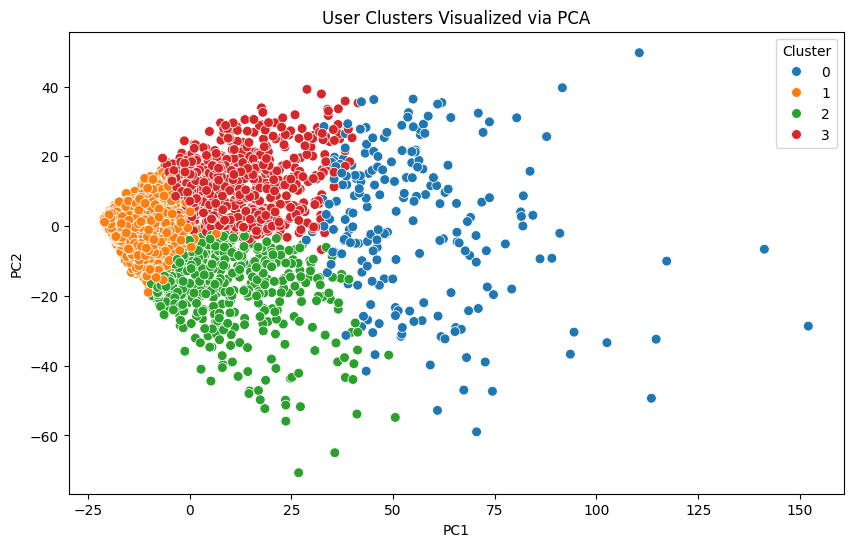

In [250]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@4 and Recall@4

In [251]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [252]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,1
2,446384,31318,10.0,3
3,400930,3712,8.0,0
4,153921,37520,8.0,0


In [253]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [254]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@4: {mean_precision:.6f}")
print(f"Recall@4: {mean_recall:.6f}")

Precision@4: 0.006948
Recall@4: 0.000376


#### Training K = 5

In [255]:
# create cluster
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 5

In [256]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [257]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.029378


##### Davies-Bouldin Index

In [258]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 4.887560


##### Visualize clusters

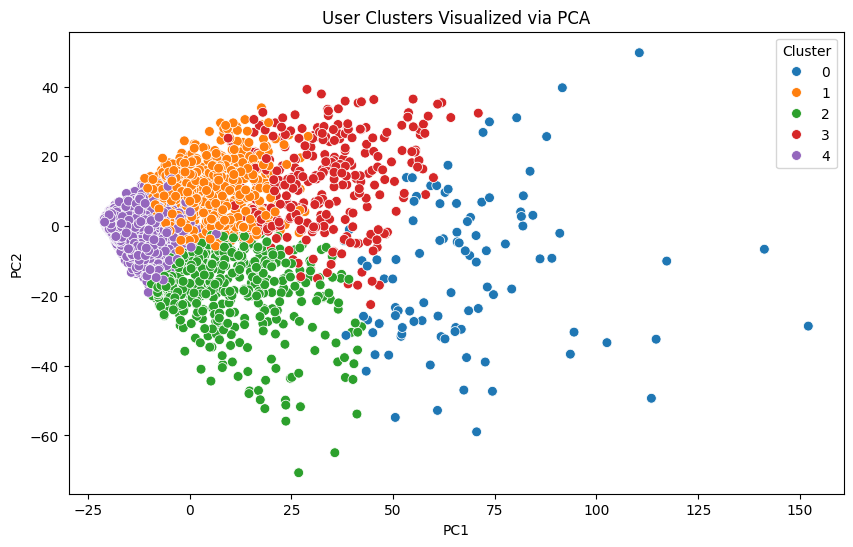

In [259]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@5 and Recall@5

In [260]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [261]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,4
2,446384,31318,10.0,3
3,400930,3712,8.0,0
4,153921,37520,8.0,3


In [262]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [263]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@5: {mean_precision:.6f}")
print(f"Recall@5: {mean_recall:.6f}")

Precision@5: 0.003828
Recall@5: 0.000155


#### Training K = 6

In [264]:
# create cluster
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 6

In [265]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [266]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.031468


##### Davies-Bouldin Index

In [267]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 5.011471


##### Visualize clusters

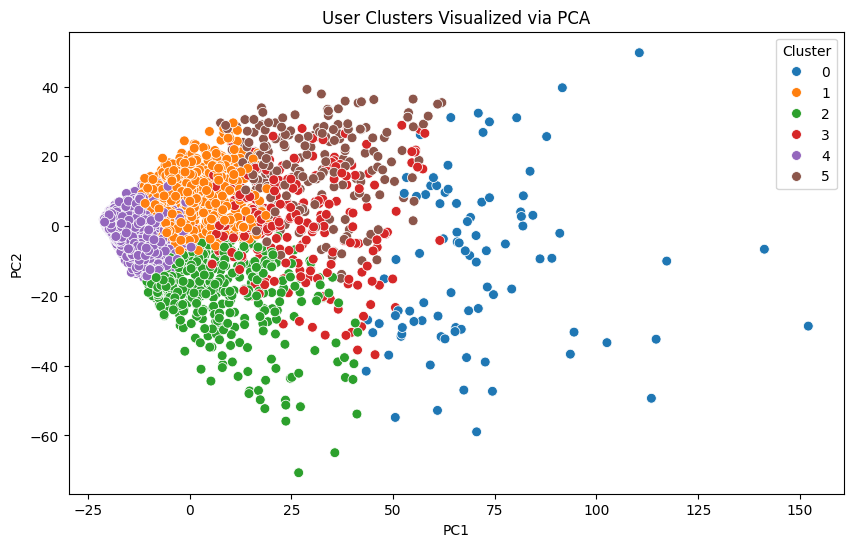

In [268]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@6 and Recall@6

In [269]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [270]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,4
2,446384,31318,10.0,5
3,400930,3712,8.0,0
4,153921,37520,8.0,5


In [271]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [272]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@6: {mean_precision:.6f}")
print(f"Recall@6: {mean_recall:.6f}")

Precision@6: 0.001418
Recall@6: 0.000053


#### Training K = 7

In [273]:
# create cluster
k = 7
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 7

In [274]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [275]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.032445


##### Davies-Bouldin Index

In [276]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 4.883651


##### Visualize clusters

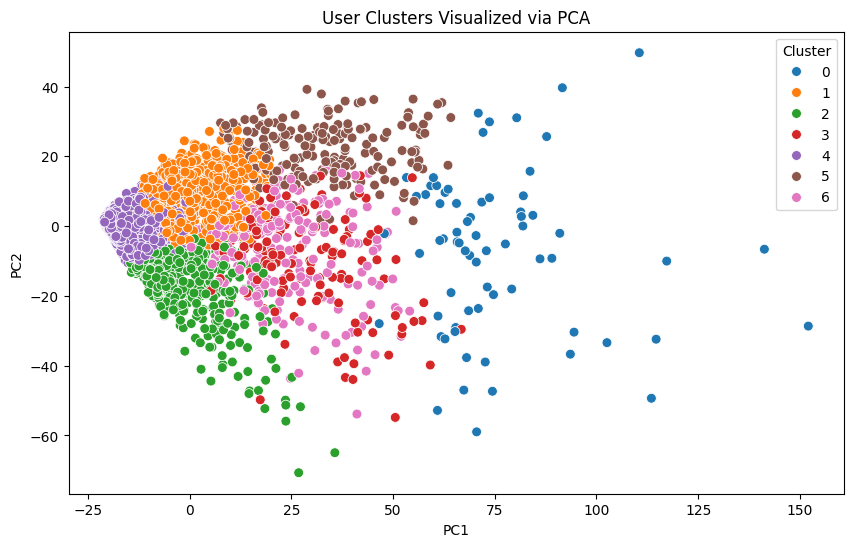

In [277]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@7 and Recall@7

In [278]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [279]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,4
2,446384,31318,10.0,5
3,400930,3712,8.0,0
4,153921,37520,8.0,5


In [280]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [281]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@7: {mean_precision:.6f}")
print(f"Recall@7: {mean_recall:.6f}")

Precision@7: 0.001276
Recall@7: 0.000047


#### Training K = 8

In [282]:
# create cluster
k = 8
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 8

In [283]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [284]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.032054


##### Davies-Bouldin Index

In [285]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 5.124099


##### Visualize clusters

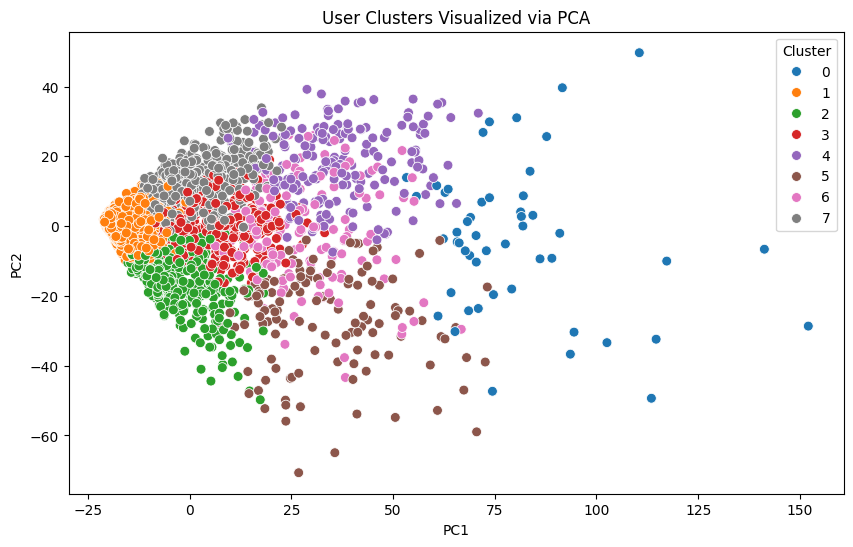

In [286]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@8 and Recall@8

In [287]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [288]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,1
2,446384,31318,10.0,4
3,400930,3712,8.0,0
4,153921,37520,8.0,4


In [289]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [290]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@8: {mean_precision:.6f}")
print(f"Recall@8: {mean_recall:.6f}")

Precision@8: 0.001134
Recall@8: 0.000042


#### Training K = 9

In [291]:
# create cluster
k = 9
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 9

In [292]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [293]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.034246


##### Davies-Bouldin Index

In [294]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 4.943429


##### Visualize clusters

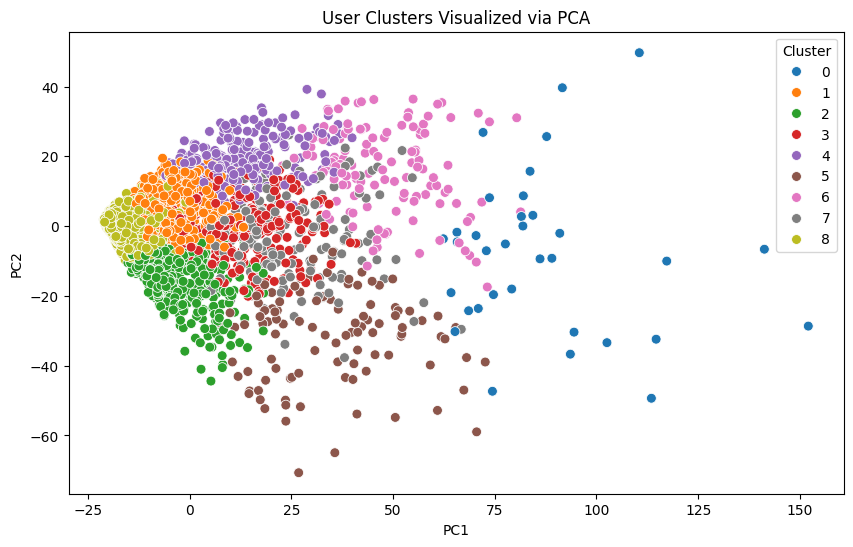

In [295]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@9 and Recall@9

In [296]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [297]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,8
2,446384,31318,10.0,4
3,400930,3712,8.0,0
4,153921,37520,8.0,6


In [298]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [299]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@9: {mean_precision:.6f}")
print(f"Recall@9: {mean_recall:.6f}")

Precision@9: 0.000496
Recall@9: 0.000016


#### Training K = 10

In [300]:
# create cluster
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 10

In [301]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [302]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.033874


##### Davies-Bouldin Index

In [303]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 5.136440


##### Visualize clusters

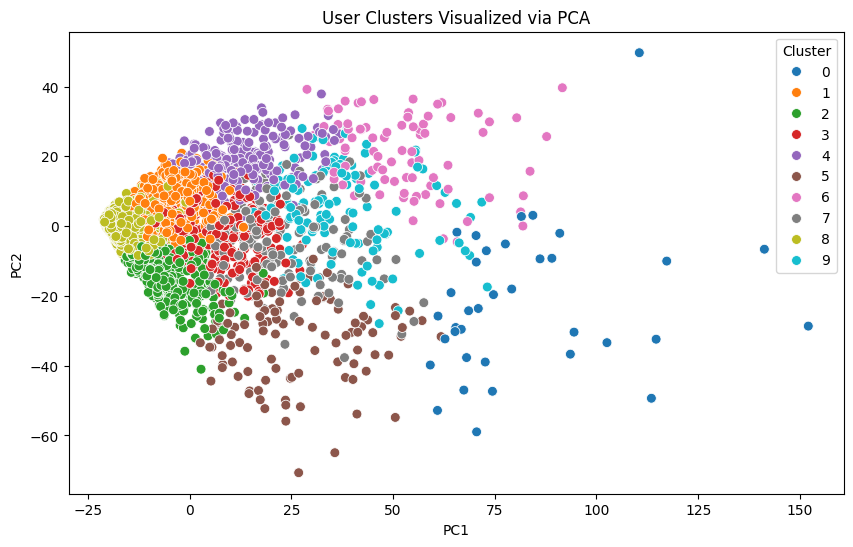

In [304]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@10 and Recall@10

In [305]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [306]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,2
2,446384,31318,10.0,6
3,400930,3712,8.0,0
4,153921,37520,8.0,6


In [307]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [308]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@10: {mean_precision:.6f}")
print(f"Recall@10: {mean_recall:.6f}")

Precision@10: 0.000425
Recall@10: 0.000011


#### Training K = 11

In [309]:
# create cluster
k = 11
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 11

In [310]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [311]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.033710


##### Davies-Bouldin Index

In [312]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 5.098260


##### Visualize clusters

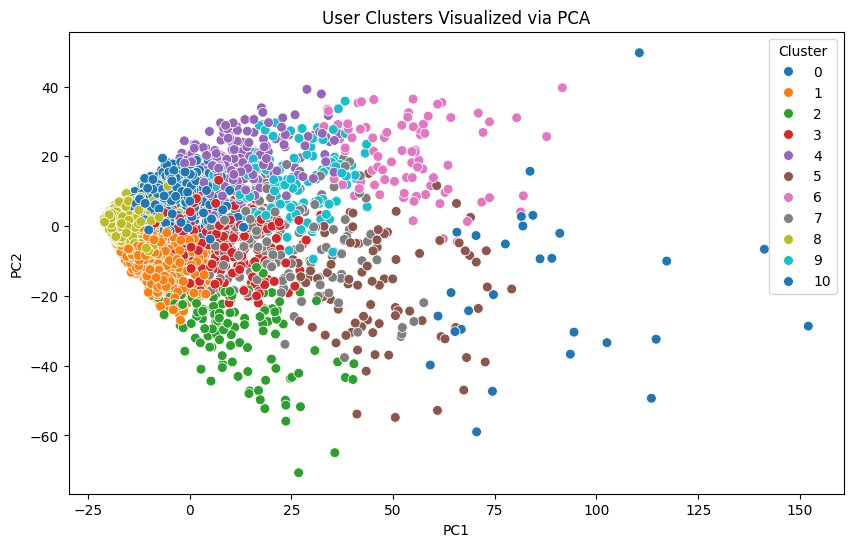

In [313]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@11 and Recall@11

In [314]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [315]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,2
1,447249,2033,7.0,1
2,446384,31318,10.0,6
3,400930,3712,8.0,0
4,153921,37520,8.0,6


In [316]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [317]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@11: {mean_precision:.6f}")
print(f"Recall@11: {mean_recall:.6f}")

Precision@11: 0.000000
Recall@11: 0.000000


#### Training K = 12

In [318]:
# create cluster
k = 12
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

inertia.append(kmeans.inertia_)

#### Assessing K = 12

In [319]:
sample_labels = cluster_labels[sample_indices]

##### Silhouette

In [320]:
sil_score = silhouette_score(sample_matrix, sample_labels, metric='cosine')
print(f"Silhouette Score: {sil_score:.6f}")
silhoutte_scores.append(sil_score)

Silhouette Score: -0.034318


##### Davies-Bouldin Index

In [321]:
db_score = davies_bouldin_score(sample_matrix.toarray(), sample_labels)
print(f"Davies–Bouldin Index: {db_score:.6f}")
davies_bouldin_scores.append(db_score)

Davies–Bouldin Index: 4.960168


##### Visualize clusters

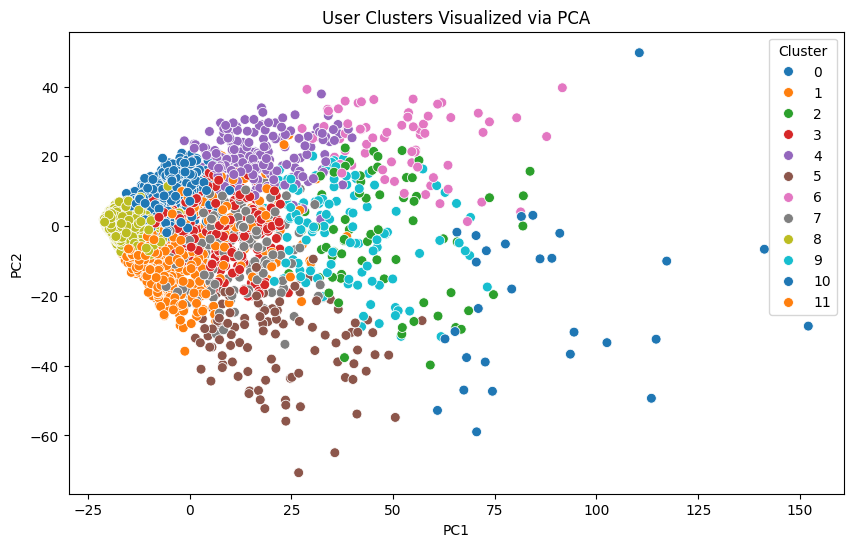

In [322]:
# visualize inspect the clusters
pca = PCA(n_components=2)
user_2d = pca.fit_transform(sample_matrix.toarray())

df_plot = pd.DataFrame({
    'x': user_2d[:, 0],
    'y': user_2d[:, 1],
    'cluster': sample_labels
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab10', s=50)
plt.title("User Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster')
plt.savefig(f"{plots_location}\\plots\\user_clusters_k_{k}.png")
plt.show()

##### Precision@12 and Recall@12

In [323]:
# assign cluster to users
clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

In [324]:
clusters_train_df.head()

,user_id,anime_id,rating,cluster
0,287522,522,8.0,7
1,447249,2033,7.0,11
2,446384,31318,10.0,6
3,400930,3712,8.0,0
4,153921,37520,8.0,6


In [325]:
# calulate mean rating for each anime across a cluster
cluster_mean_ratings_df = clusters_train_df.drop(columns=["user_id"]) \
    .groupby(["cluster", "anime_id"]).mean().reset_index()

In [326]:
precisions, recalls = [], []
for user_id in sample_index_to_user.values():
    p, r = precision_recall_at_k(user_id, k=5)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

precision_scores.append(mean_precision)
recall_scores.append(mean_recall)

print(f"Precision@12: {mean_precision:.6f}")
print(f"Recall@12: {mean_recall:.6f}")

Precision@12: 0.001347
Recall@12: 0.000090


#### Assessing Inertia, Silhouette and Davies-Bouldin Scores

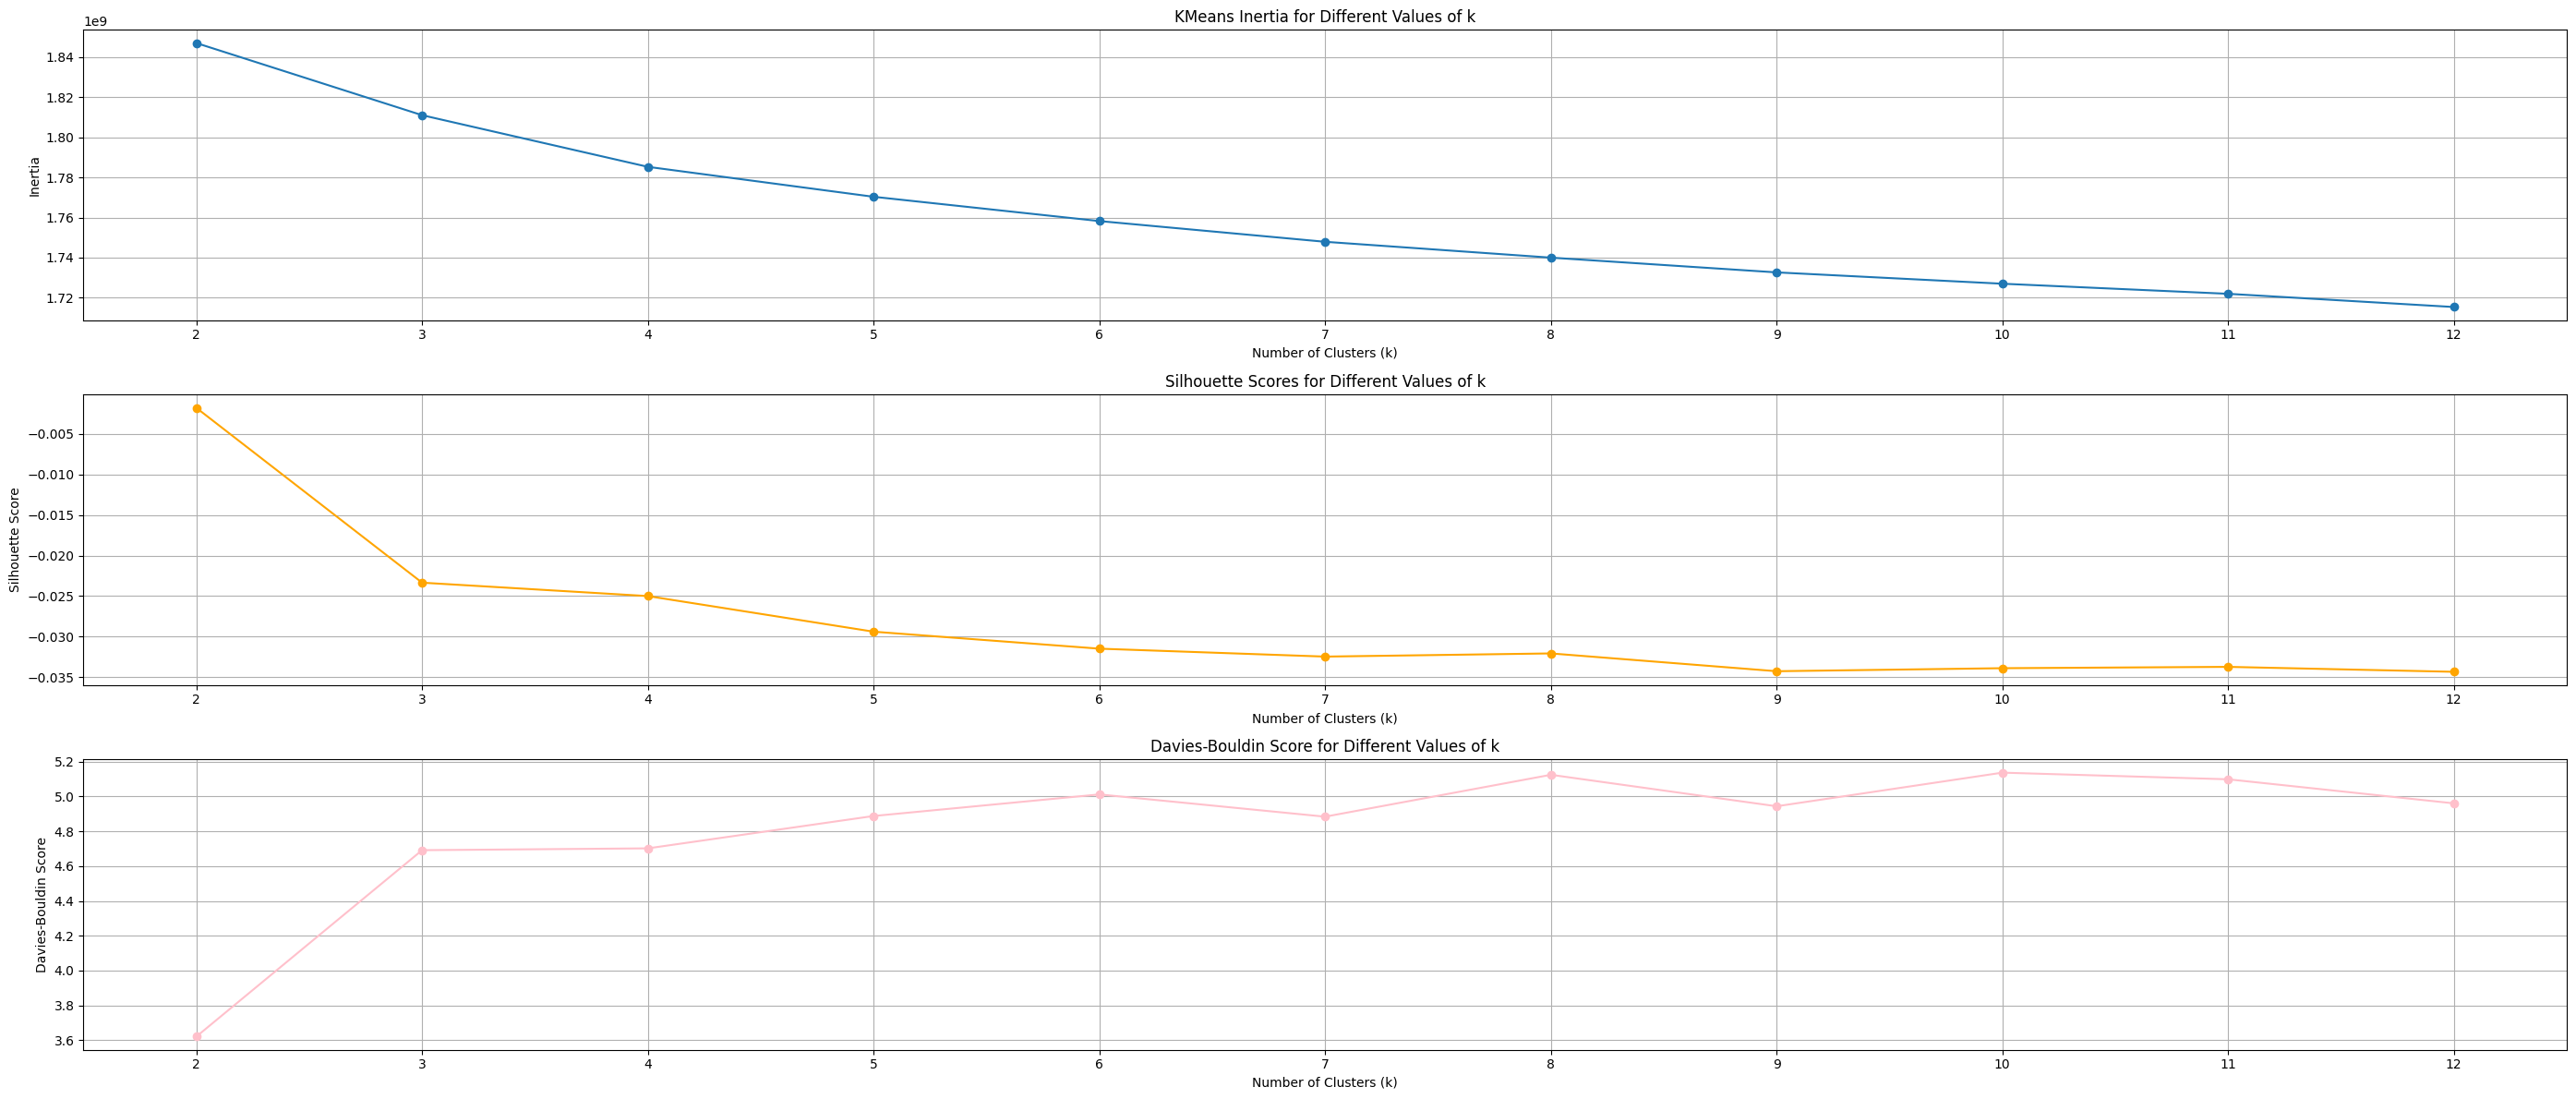

In [ ]:
k_values = range(2, 13)

plt.figure(figsize=(28, 12))
plt.subplot(3, 1, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(k_values, davies_bouldin_scores, marker='o', color='pink')
plt.title('Davies-Bouldin Score for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.savefig(f"{plots_location}\\plots\\inertia_silhouette_davies_bouldin.png")
plt.show()

#### Comparing Precision@K and Recall@K

In [328]:
recommendation_metrics_df = pd.DataFrame(columns=["K", "Precision", "Recall"])
recommendation_metrics_df["K"] = [i for i in range(2, 13)]
recommendation_metrics_df["Precision"] = precision_scores
recommendation_metrics_df["Recall"] = recall_scores

In [330]:
recommendation_metrics_df

,K,Precision,Recall
0,2,0.017795,0.001476
1,3,0.007657,0.000430
2,4,0.006948,0.000376
3,5,0.003828,0.000155
4,6,0.001418,0.000053
5,7,0.001276,0.000047
6,8,0.001134,0.000042
7,9,0.000496,0.000016
8,10,0.000425,0.000011
9,11,0.000000,0.000000


In [332]:
recommendation_metrics_df.to_csv(f"{plots_location}\\metrics\\precision_and_recall.csv", index=False)

k-means @ 4 is chosen for the model as it provides the best clusters based on visual inspection as well as the inertia, silhouette and davies-bouldin scores

In [ ]:
import joblib
# create cluster
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=300)
cluster_labels = kmeans.fit_predict(user_item_sparse)

clusters_df = pd.DataFrame({
    'user_id' : [index_to_user[i] for i in range(len(cluster_labels))],
    'cluster': cluster_labels
})

clusters_train_df = train_df.merge(clusters_df, on="user_id")

model_bundle = {
    'kmeans': kmeans,
    'df': clusters_train_df,
    'id_to_user': index_to_user,
    'id_to_anime': index_to_anime
}

# Store to file
joblib.dump(model_bundle, "E:\\applied data science capstone\\clusters\\user_clustering_model.joblib")
#